In [3]:
# import required libraries
import torch
from PIL import Image, ImageDraw
import os
import matplotlib.pyplot as plt
import cv2 as cv
import time
import numpy as np 
import torchvision.models as models
from PIL import Image
import torch.nn as nn

In [4]:
def setDevice():
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    print(f"Using {device}")
    return device

In [5]:
def loadYoloModel():
    model = torch.hub.load("ultralytics/yolov5", "yolov5s", pretrained=True)
    return model

In [21]:
def detectSingleImage(imagePath, device, model):
    start = time.time()

    image = Image.open(imagePath).convert('RGB')
    with torch.no_grad():
        result = model(image)
        result.print()
        #print(result.xyxy)
        #print("Names")
        #print(result.pandas().xyxy[0]["name"])
        resultNames = result.pandas().xyxy[0]["name"]
        predictions = result.xyxy[0]

        for i in range(len(predictions)):
            prediction = predictions[i].tolist()
            # print(prediction)
            #print(f"prediction {i}, {resultNames[i]}")
            #print(prediction)
            if resultNames[i] == "person":
                indexOfClosest = None
                distance = image.size[0]
                for j in range(len(predictions)):
                    prediction2 = predictions[j].tolist()

                    if resultNames[j] == "person":
                        continue
                    else:
                        #print("prediction for non human object")
                        #print(prediction2)

                        # pil image pixel value changing
                        temp = np.array(image)

                        # debug (draw one pixel green)
                        #print("coordinates")
                        #print(round(prediction2[0]))
                        #print(round(prediction2[1]))
                        temp[round(prediction2[1])][round(prediction2[0])]   = [0, 255, 0]
                        image = Image.fromarray(temp)
                        # debug

                        personCenters = (
                            (prediction[2] + prediction[0]) // 2, # (xmax + xmin) / 2  -> x but column value
                            (prediction[3] + prediction[1]) // 2  # (ymax + ymin) / 2  -> y but row value
                        )

                        objCenters = (
                            (prediction2[2] + prediction2[0]) // 2, # (xmax + xmin) / 2  -> x but column value
                            (prediction2[3] + prediction2[1]) // 2  # (ymax + ymin) / 2  -> y but row value
                        )
                        ImageDraw.Draw(image).line((personCenters[0],personCenters[1], objCenters[0], objCenters[1] ), fill="orange", width=1)

                        radius = 4
                        ImageDraw.Draw(image).ellipse((personCenters[0]-radius,personCenters[1]-radius,personCenters[0]+radius, personCenters[1]+radius), fill="green", outline="green")
                        ImageDraw.Draw(image).ellipse((objCenters[0]-radius,objCenters[1]-radius,objCenters[0]+radius, objCenters[1]+radius), fill="blue", outline="blue")


            x_min = round(prediction[0])
            y_min = round(prediction[1])
            x_max = round(prediction[2])
            y_max = round(prediction[3])
            cfdnc = round(prediction[4])
            color = None
            if resultNames[i] == "person":
                color = "purple"
            else:
                color = "red"  
            ImageDraw.Draw(image).rectangle([x_min,y_min,x_max,y_max], outline =color)
    
    print(f"Took {time.time()-start} seconds.")
    return image

In [17]:
# set device
device = setDevice()

Using cuda


In [10]:
# loading pretrained model
yoloModel = loadYoloModel()
yoloModel

Using cache found in C:\Users\Berkay/.cache\torch\hub\ultralytics_yolov5_master
Fusing layers... 
Model Summary: 224 layers, 7266973 parameters, 0 gradients
Adding AutoShape... 
YOLOv5  2021-6-7 torch 1.8.1 CUDA:0 (NVIDIA GeForce GTX 1650 Ti, 4096.0MB)



AutoShape(
  (model): Model(
    (model): Sequential(
      (0): Focus(
        (conv): Conv(
          (conv): Conv2d(12, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
      (2): C3(
        (cv1): Conv(
          (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (cv3): Conv(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (m): Sequential(
          (0): Bottleneck(
            (cv1): Conv(
              (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
              (act): SiLU(inplace=True)
            )
    

image 1/1: 640x640 5 persons, 1 sports ball
Speed: 4.5ms pre-process, 62.9ms inference, 1.6ms NMS per image at shape (1, 3, 640, 640)
Took 0.09883379936218262 seconds.


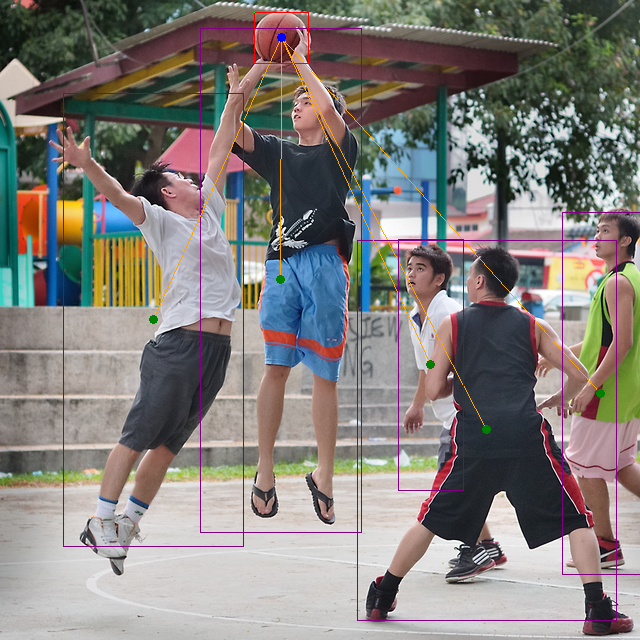

In [27]:
resultImage = detectSingleImage("./HICO_train2015_00000178.jpg", device, yoloModel)
resultImage